# __Bayes Ingenuo__

## Alcance
<ul>
<li>Identificar los componentes del Teorema de Bayes.</li>
<li>Reconocer el problema de probabilidad inversa y su solución con Bayes Ingenuo.</li>
<li>Reconocer las diferentes formas de Bayes Ingenuo.</li>
<li>Implementar algoritmos de Bayes Ingenuo con sklearn.</li>
</ul>

In [1]:
# añadimos las librerías clásicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lec3_graphs as gfx
# añadimos seaborn
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
df = pd.read_csv('ucbadmissions.csv').drop(columns='Unnamed: 0')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Admit   24 non-null     object
 1   Gender  24 non-null     object
 2   Dept    24 non-null     object
 3   Freq    24 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 896.0+ bytes


In [3]:
df_deagg = gfx.deaggregate_statistics(df)

In [4]:
df_deagg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4526 entries, 0 to 4525
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Admit   4526 non-null   object
 1   Gender  4526 non-null   object
 2   Dept    4526 non-null   object
dtypes: object(3)
memory usage: 106.2+ KB


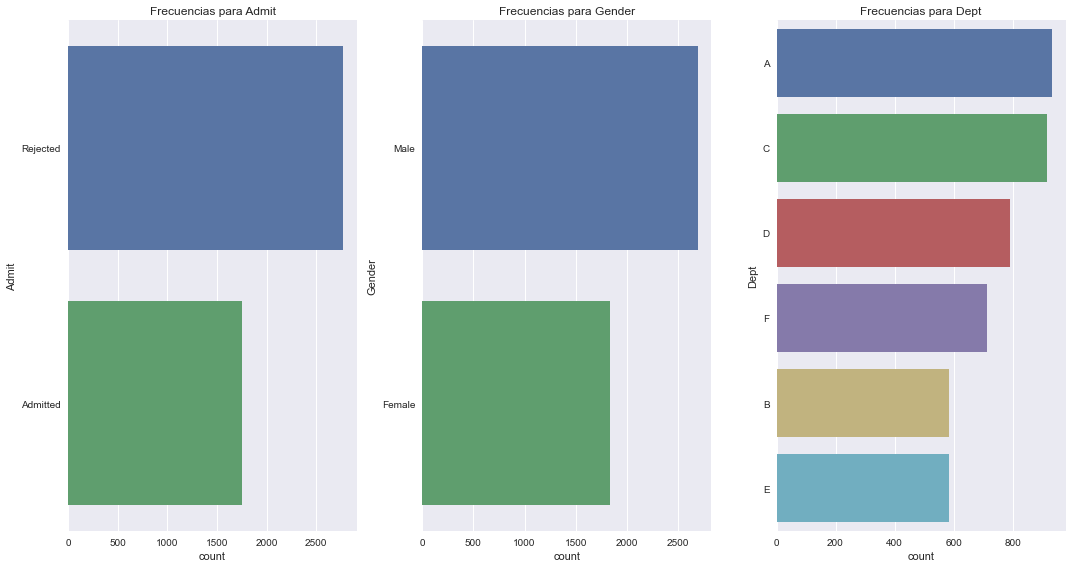

In [5]:
# definimos un canvas con tamaños fijos para mejorar la presentación
plt.figure(figsize=(15, 8))
# para cada elemento de nuestra columna, devuelve un número (n) y el elemento (i)
for n, i in enumerate(['Admit', 'Gender', 'Dept']):
    # generamos tres subplots en una fila
    plt.subplot(1, 3, n + 1)
    # generamos un contador de frecuencia con seaborn
    sns.countplot(y= df_deagg[i],
    # ordenamos las frecuencias de mayor a menor
    order = df_deagg[i].value_counts().index)
    # agregamos el título
    plt.title('Frecuencias para {}'.format(i))
    # mejoramos los márgenes
    plt.tight_layout()

In [6]:
# importamos los módulos de sklearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
lbl = LabelEncoder()
# Implementamos el método fit_transform para actualizar y sobreescribir cada columna de atributos
df_deagg['Gender'] = lbl.fit_transform(df_deagg['Gender'])
df_deagg['Admit'] = lbl.fit_transform(df_deagg['Admit'])
# generamos una serie de dummies en base a Dept y las concatenamos a nuestra base.
# posteriormente, eliminamos la columna Dept
df_deagg = pd.concat([df_deagg, pd.get_dummies(df_deagg['Dept'], prefix='dept')], axis=1).drop(columns='Dept')


In [7]:
df_deagg.sample()

,Admit,Gender,dept_A,dept_B,dept_C,dept_D,dept_E,dept_F
3969,1,1,0,0,0,0,0,1


In [8]:
X_train_mat, X_test_mat, y_train_vec, y_test_vec = train_test_split(df_deagg.loc[:, 'Gender':'dept_F'], df_deagg['Admit'], test_size=.30, random_state=11238)


In [9]:
nb_classifier = BernoulliNB()
nb_classifier.fit(X_train_mat, y_train_vec)
nb_log_prob_pred = nb_classifier.predict_log_proba(X_test_mat)
nb_prob_pred = nb_classifier.predict_proba(X_test_mat)


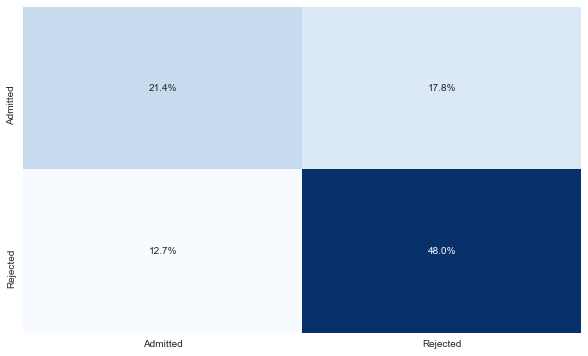

In [10]:
from sklearn.metrics import classification_report
# en base a un vector de clases predichas
y_hat = nb_classifier.predict(X_test_mat)
# generar una matriz confusa donde el primer argumento es el vector de prueba
# y el segundo es el vector de clases predichas.
# el resultado lo dividimos por el largo del vector de prueba
# para obtener un porcentaje por sobre la cantidad de casos
cnf = confusion_matrix(y_test_vec, y_hat)/len(y_test_vec)
# guardamos las etiquetas de las clases
target_label = ['Admitted', 'Rejected']
# Implementamos un mapa de calor definiendo las clases
sns.heatmap(cnf, xticklabels=target_label,
yticklabels=target_label,
# generamos las anotaciones en términos porcentuales
annot=True, fmt=".1%",
# evitamos la barra y cambiamos el colormap
cbar=False, cmap='Blues');

In [11]:
print(classification_report(y_test_vec, y_hat))

              precision    recall  f1-score   support

           0       0.63      0.55      0.58       533
           1       0.73      0.79      0.76       825

    accuracy                           0.69      1358
   macro avg       0.68      0.67      0.67      1358
weighted avg       0.69      0.69      0.69      1358



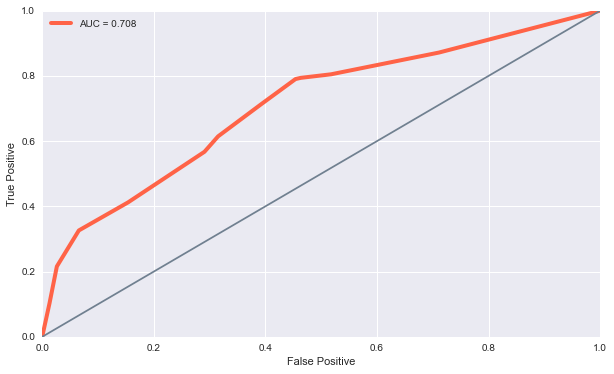

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
# para implementar el área bajo la curva necesitamos el puntaje
# de probabilidad, no la clase predicha. Para ello implementamos predict_proba
y_hat_pr = nb_classifier.predict_proba(X_test_mat)[:,1]
# el método roc_curve devuelve 3 elementos: falsos positivos, verdaderos positivos,
# y threshold. Este último lo podemos ignorar con _
fpr, tpr, _ = roc_curve(y_test_vec, y_hat_pr)
# podemos obtener el área bajo la curva roc con roc_auc_score
auc = round(roc_auc_score(y_test_vec, y_hat_pr), 3)
# graficamos
plt.plot(fpr, tpr, label="AUC = {}".format(auc), color='tomato', lw=4)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.axis([0, 1, 0, 1])
# graficamos el clasificador por chance.
plt.plot([0, 1], [0, 1], color='slategrey')
plt.legend();